In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import corner
import emcee
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde

from analysis import *

In [20]:
def plot_data(x, y, y_err, models=None):
    fig, ax = plt.subplots()

    ax.errorbar(x, y, y_err, fmt=".", label="Data")

    if models is not None:
        for model_def in models:
            if "lower" in model_def:
                ax.fill_between(
                    model_def["x"], model_def["lower"], model_def["upper"],
                    **model_def.get("style", {})
                )
            else:
                ax.plot(
                    model_def["x"], model_def["y"],
                    **model_def.get("style", {})
                )

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.legend(frameon=False)

    return fig, ax


def analyse_data(data,
                 log_posterior_fn, model_fn, predict_fn,
                 param_names, theta_true):

    x, y, sigma_y = data["x"], data["y"], data["y_err"]

    theta_init = theta_true

    true_model_plot_def = dict(
        x=x, y=model_fn(*theta_true, x),
        style=dict(color="black", ls="--", label="True model")
    )

    # Find the MAP
    def negative_log_posterior(theta, x, sigma_y, y):
        return -log_posterior_fn(*theta, x, sigma_y, y)
    
    MAP_result = scipy.optimize.minimize(
        fun=negative_log_posterior,
        x0=theta_init,
        args=(x, sigma_y, y)
    )
    theta_MAP = MAP_result.x

    print("MAP results")
    for name, theta in zip(param_names, theta_MAP):
        print(f"{name}_MAP = {theta}")
    
    plot_data(
        x=x, y=y, y_err=sigma_y,
        models=[
            true_model_plot_def,
            dict(x=x, y=model_fn(*theta_MAP, x),
                 style=dict(color="C1", label="MAP model")),
        ]
    )

    # Sample posterior with emcee

    # emcee passes an array of values for the sampled parameters
    # This wrapper just splits the array theta into m and b
    def log_posterior_wrapper(theta, x, sigma_y, y):
        return log_posterior_fn(*theta, x, sigma_y, y)

    # emcee requires some extra settings to run
    n_param = len(theta_true) # Number of parameter we are sampling
    n_walker = 10             # Number of walkers. This just needs to be larger than 2*n_param + 1
    n_step = 5000             # How many steps each walker will take. The number of samples will be n_walker*n_step

    # The starting point for each walker
    theta_init = theta_init + 0.1*np.random.normal(size=(n_walker, n_param))

    sampler = emcee.EnsembleSampler(
        nwalkers=n_walker, ndim=n_param,
        log_prob_fn=log_posterior_wrapper,
        args=(x, sigma_y, y)
    )
    state = sampler.run_mcmc(theta_init, nsteps=n_step, progress=True)

    # The samples will be correlated, this checks how correlated they are
    # We will discuss this once we come to MCMC methods
    print("Auto-correlation time of chain:")
    for name, value in zip(param_names, sampler.get_autocorr_time()):
        print(f"{name} = {value:.1f}")

    max_autocorr_time = max(sampler.get_autocorr_time())

    # We need to discard the beginning of the chain (a few auto-correlation times)
    # to get rid of the initial conditions
    chain = sampler.get_chain(
        discard=int(5*max_autocorr_time),
        thin=int(max_autocorr_time/2),
        flat=True
    )


    kde = gaussian_kde(chain.T)
    mode_nd = chain[np.argmax(kde(chain.T)), :]

    # Make a corner plot
    fig = plt.figure()
    fig = corner.corner(
        chain,
        bins=40,
        labels=param_names,
        truths=mode_nd,
        levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding to 1 and 2 sigma in 2D
        quantiles=[0.025, 0.16, 0.84, 0.975],
        fig=fig
    )

    print("Posterior results (mean±std)")
    for i, name in enumerate(param_names):
        print(f"{name} = {np.mean(chain[:,i]):.2f}±{np.std(chain[:,i]):.2f}")

    # Make predictive distributions
    # Choose a small subsample of the chain for plotting purposes
    chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
    # Evaluate the model at the sample parameters
    model_predictive = np.array(
        [model_fn(*sample, x) for sample in chain_samples]
    )
    model_quantiles = np.quantile(
        model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )

    # Get samples from the posterior predictive distribution
    posterior_predictive = np.array(
        [predict_fn(*sample, x, sigma_y) for sample in chain_samples]
    )
    posterior_predictive_quantiles = np.quantile(
        posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )

    # Make plots of the data, best-fit model, and predictive distributions
    plot_data(
        x=x, y=y, y_err=sigma_y,
        models=[
            true_model_plot_def,
            dict(x=x, y=model_fn(*theta_MAP, x),
                 style=dict(color="C1", label="MAP model")),
            
            dict(x=x, lower=model_quantiles[0], upper=model_quantiles[-1],
                 style=dict(color="C1", alpha=0.5, label="Model predictions")),
            dict(x=x, lower=model_quantiles[1], upper=model_quantiles[-2],
                 style=dict(color="C1", alpha=0.5)),

            dict(x=x, lower=posterior_predictive_quantiles[0], upper=posterior_predictive_quantiles[-1],
                 style=dict(color="grey", alpha=0.5, label="Posterior predictions")),
            dict(x=x, lower=posterior_predictive_quantiles[1], upper=posterior_predictive_quantiles[-2],
                 style=dict(color="grey", alpha=0.5)),
        ]
    )

In [21]:
# Load the CSV file
df = pd.read_csv('table_65exo.csv')

# Sort the DataFrame by the 'radius' column (in ascending order)
df_sorted = df.sort_values(by=df.columns[5])

# Reset the index if you want a clean, sequential index
df_sorted = df_sorted.reset_index(drop=True)


radius = df_sorted.iloc[:, 5]
sigma_radius = df_sorted.iloc[:, 6]
mass = df_sorted.iloc[:, 3]
sigma_mass = df_sorted.iloc[:, 4]

In [22]:
def model(a, b, x):
    return a*x**b

# We use the logarithm here for computational reasons
def log_likelihood(mass, a, b, radius, sigma_mass):
    prediction = model(a, b, radius)

    n = len(mass)
    return (
        -0.5 * np.sum((mass - prediction)**2/sigma_mass**2)      # Exponent
        - n/2*np.log(2*np.pi*sigma_mass**2)                   # Normalisation
    )

def log_prior(a, b):
    mi_a = 1
    mi_b = 1

    sigma_a = 3
    sigma_b = 3

    return (
        -0.5*(a-mi_a)**2/sigma_a**2      # m exponent
        -0.5*(b-mi_b)**2/sigma_b**2      # b exponent
        - 0.5*np.log(2*np.pi*sigma_a**2) # Normalisation
        - 0.5*np.log(2*np.pi*sigma_b**2) # Normalisation
    )

def log_posterior(a, b, radius, sigma_mass, mass):
    return log_likelihood(mass, a, b, radius, sigma_mass) + log_prior(a, b)

# Predict new data, given parameters
def predict(a, b, radius, sigma_mass):
    mi = model(a, b, radius)
    return np.random.normal(loc=mi, scale=sigma_mass)

MAP results
a_MAP = 2.3590030557906965
b_MAP = 1.1657929514877223


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 259.44it/s]


Auto-correlation time of chain:
a = 30.3
b = 33.9
Posterior results (mean±std)
a = 2.40±0.42
b = 1.16±0.17


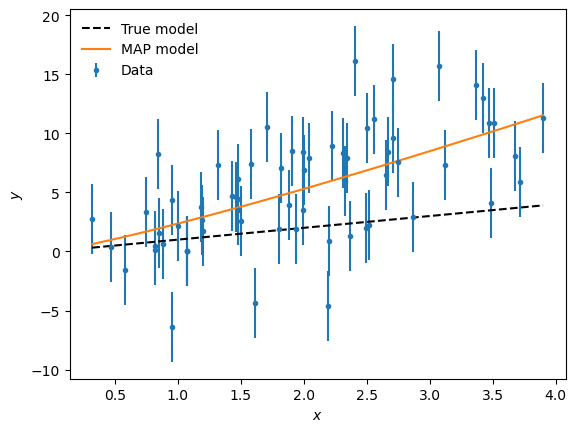

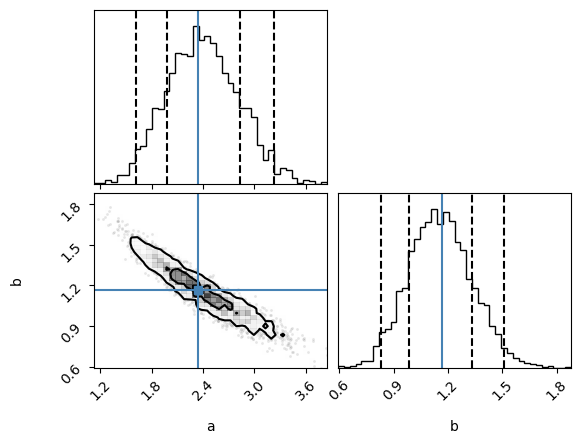

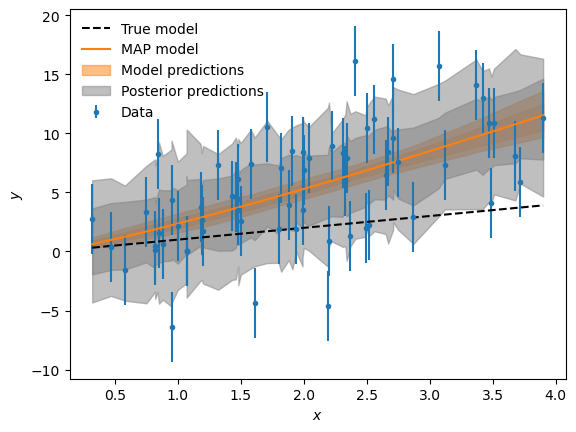

In [23]:
analyse_data(
    data=dict(x=radius, y=mass, y_err=np.mean(sigma_mass)),
    log_posterior_fn=log_posterior,
    model_fn=model,
    predict_fn=predict,
    param_names=["a", "b"],
    theta_true=[1, 1],
)

MAP results
a_MAP = 3.011946061558032
b_MAP = 0.8484475580824601


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 142.16it/s]


Auto-correlation time of chain:
a = 32.5
b = 30.2
Posterior results (mean±std)
a = 3.02±0.18
b = 0.85±0.06


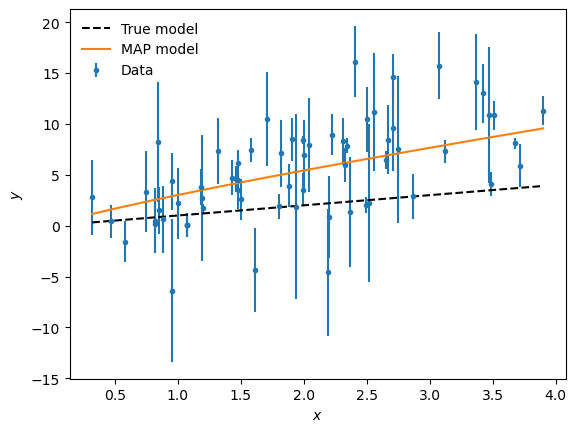

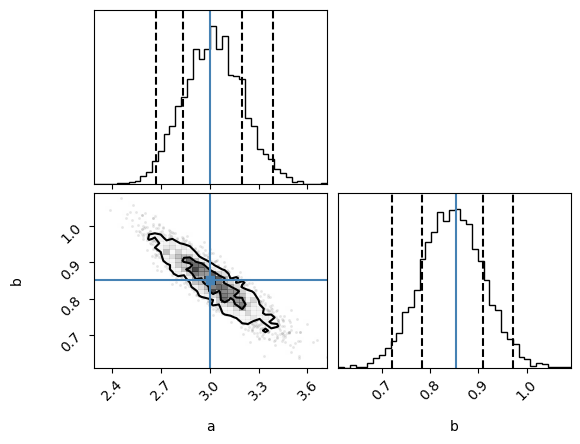

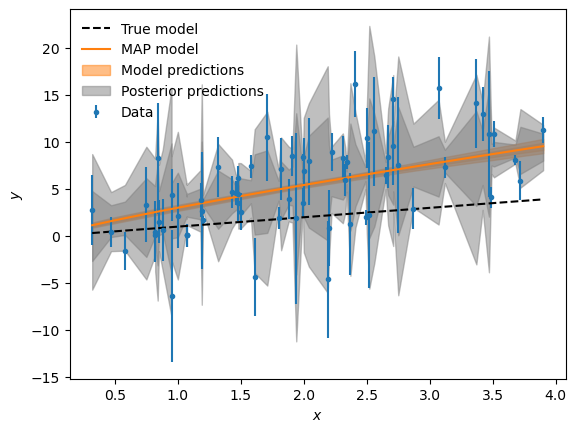

In [24]:
# Because the error is now different for each data point, we need to adapt the
# likelihood a bit
def log_likelihood_heteroscedastic(mass, a, b, radius, sigma_mass):
    prediction = model(a, b, radius)

    return (
        -0.5 * np.sum((mass - prediction)**2/sigma_mass**2)    # Exponent
        -0.5 * np.sum(np.log(2*np.pi*sigma_mass**2))        # Normalisation
    )

def log_posterior_heteroscedastic(a, b, radius, sigma_mass, mass):
    return log_likelihood_heteroscedastic(mass, a, b, radius, sigma_mass) + log_prior(a, b)

analyse_data(
    data=dict(x=radius, y=mass, y_err=sigma_mass),
    log_posterior_fn=log_posterior_heteroscedastic,
    model_fn=model,
    predict_fn=predict,
    param_names=["a", "b"],
    theta_true=[1, 1],
)

MAP results
a_MAP = 2.3915566366135037
b_MAP = 1.1375962362446748
f_MAP = 0.03956147236054464


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 130.31it/s]


Auto-correlation time of chain:
a = 48.9
b = 39.6
f = 43.0
Posterior results (mean±std)
a = 2.44±0.37
b = 1.09±0.21
f = 0.05±0.02


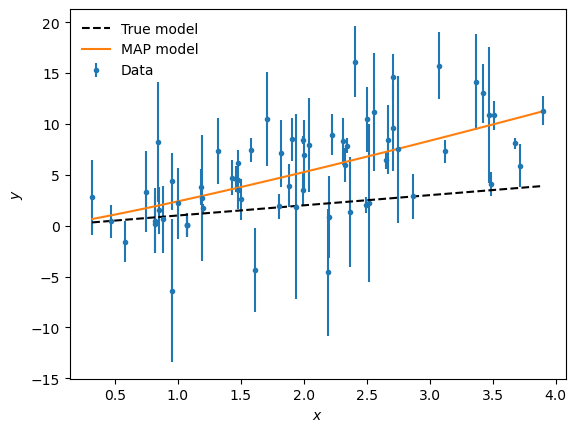

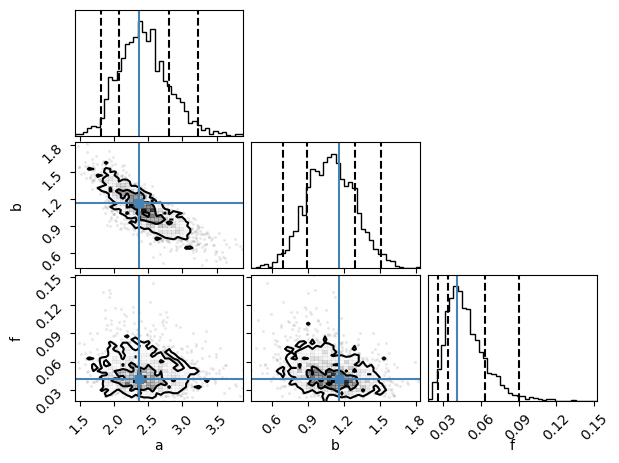

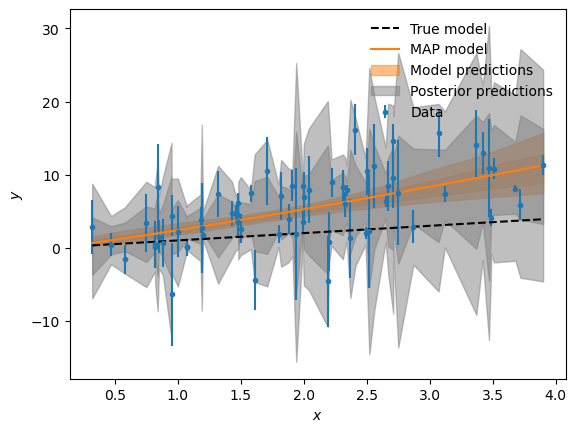

In [28]:
np.random.seed(42)

def log_likelihood_true(mass, a, b, f, radius, sigma_mass):
    prediction = model(a, b, radius)

    sigma = sigma_mass + f*prediction**2
    n = len(mass)
    return (
        -0.5 * np.sum((mass - prediction)**2/sigma**2)   # Exponent
        -0.5 * np.sum(np.log(2*np.pi*sigma**2))       # Normalisation
    )

def log_prior_true(a, b, f):
    mi_f = 0.5
    sigma_f = 1

    return log_prior(a, b) - 0.5*(f - mi_f)**2/sigma_f**2

def log_posterior_true(a, b, f, radius, sigma_mass, mass):
    return log_likelihood_true(mass, a, b, f, radius, sigma_mass) + log_prior_true(a, b, f)

def predict_true(a, b, f, radius, sigma_mass):
    mi = model(a, b, radius)
    sigma = sigma_mass + f*mi**2
    return np.random.normal(loc=mi, scale=sigma)

f_true = 0.51

analyse_data(
    data=dict(x=radius, y=mass, y_err=sigma_mass),
    log_posterior_fn=log_posterior_true,
    model_fn=lambda a, b, f, radius: model(a, b, radius),
    predict_fn=predict_true,
    param_names=["a", "b", "f"],
    theta_true=[1, 1, f_true],
)